# Testing a grid of CNT using Poisson solver

Sources:
- Enhanced surface capacitance of cylindrical micropillar arrays (for BC): Assaf Ya’akobovitz A. John Hart 
- https://courses.physics.illinois.edu/phys466/fa2016/projects/2002/team3/index.html - linearizing poisson equation


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

## Params

In [15]:
sim_dimensions = (50, 50, 30)
Nx, Ny, Nz = sim_dimensions
radius = 2
height = 10
number = 9
spacing = 15
V_input = 1
L = 50
a,b,c = L/(Nx -1), L/(Ny -1), L/(Nz -1)
Epsilon = np.ones((Nx -1, Ny -1, Nz -1)) * 10

## Creates the mesh 

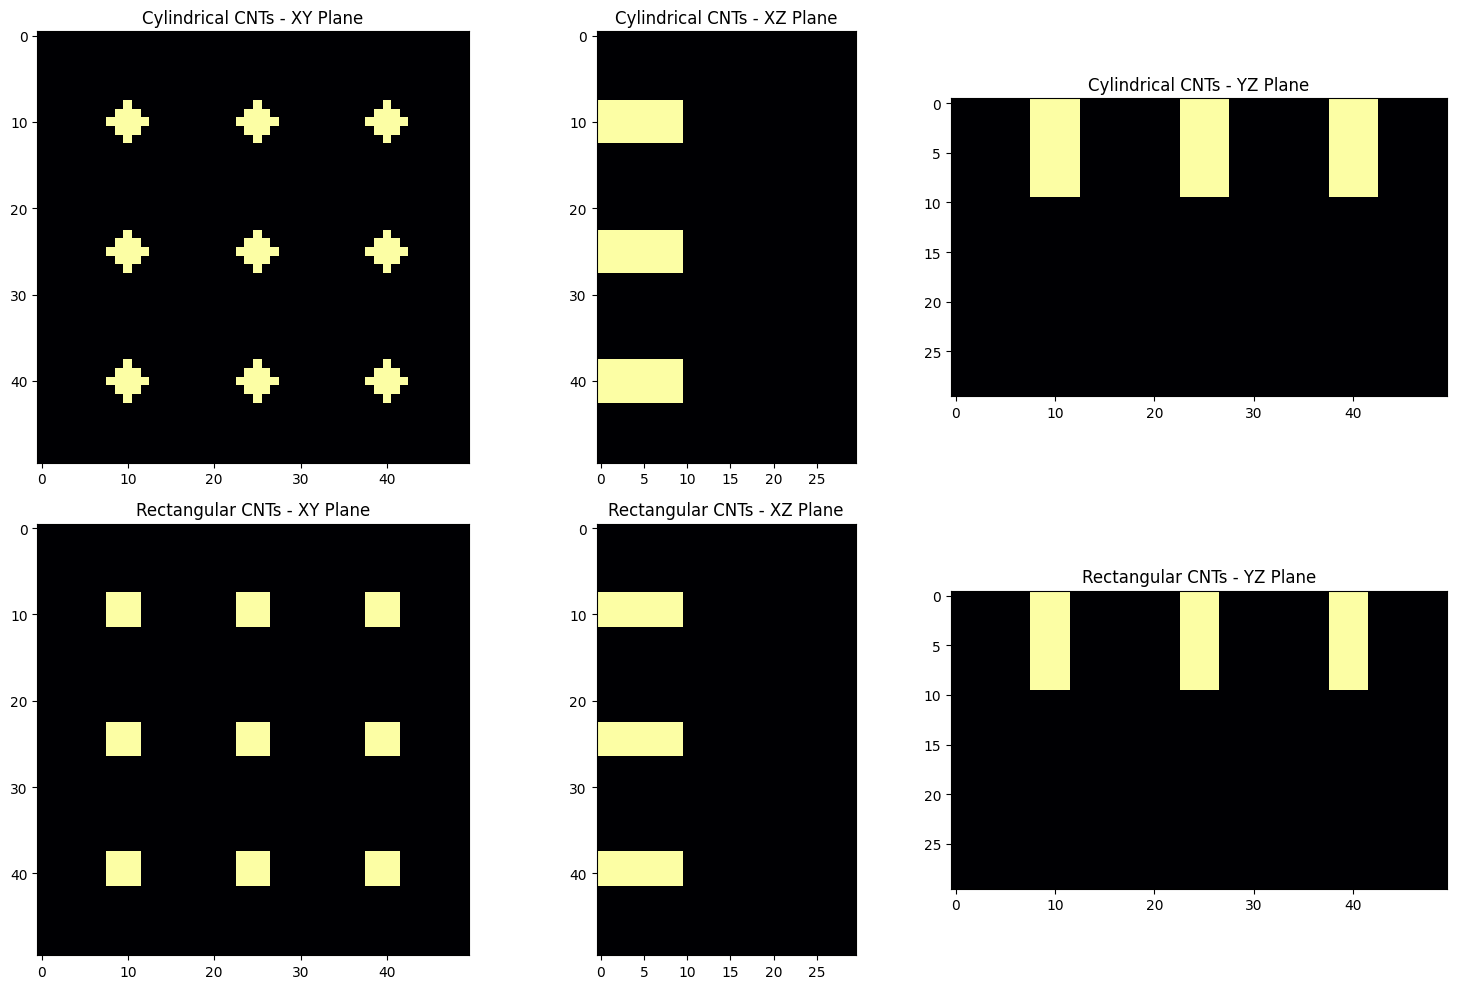

In [16]:
def CNT_mesh(radius, height, number, spacing, sim_dimensions, geometry="standard", CNT_shape="rectangular"):
    Nx, Ny, Nz = sim_dimensions
    shape = np.zeros((Nx, Ny, Nz))
    
    if geometry == "standard":
        rows = int(np.ceil(np.sqrt(number)))
        cols = int(np.ceil(number / rows))
        
        center_x = Nx // 2
        center_y = Ny // 2
        
        start_x = center_x - ((cols - 1) * spacing) // 2
        start_y = center_y - ((rows - 1) * spacing) // 2
        
        cylinder_count = 0
        for i in range(rows):
            for j in range(cols):
                if cylinder_count >= number:
                    break
                x_pos = start_x + j * spacing
                y_pos = start_y + i * spacing
                
                if CNT_shape == "cylinder":
                    for x in range(Nx):
                        for y in range(Ny):
                            if (x - x_pos)**2 + (y - y_pos)**2 <= radius**2:
                                shape[x, y, 0:height] = 1
                elif CNT_shape == "rectangle":
                    x_min = max(0, x_pos - radius)
                    x_max = min(Nx, x_pos + radius)
                    y_min = max(0, y_pos - radius)
                    y_max = min(Ny, y_pos + radius)
                    shape[x_min:x_max, y_min:y_max, 0:height] = 1

                cylinder_count += 1
    
    return shape


# Create and plot both shapes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Cylindrical CNTs
shape_cylinder = CNT_mesh(radius, height, number, spacing, sim_dimensions, CNT_shape="cylinder")
axes[0, 0].imshow(shape_cylinder[:, :, 0], cmap='inferno')
axes[0, 0].set_title('Cylindrical CNTs - XY Plane')
axes[0, 1].imshow(np.max(shape_cylinder, axis=1), cmap='inferno')  # XZ Plane
axes[0, 1].set_title('Cylindrical CNTs - XZ Plane')
axes[0, 2].imshow(np.max(shape_cylinder, axis=0).T, cmap='inferno')  # YZ Plane
axes[0, 2].set_title('Cylindrical CNTs - YZ Plane')

# Rectangular CNTs
shape_rectangle = CNT_mesh(radius, height, number, spacing, sim_dimensions, CNT_shape="rectangle")
axes[1, 0].imshow(shape_rectangle[:, :, 0], cmap='inferno')
axes[1, 0].set_title('Rectangular CNTs - XY Plane')
axes[1, 1].imshow(np.max(shape_rectangle, axis=1), cmap='inferno')  # XZ Plane
axes[1, 1].set_title('Rectangular CNTs - XZ Plane')
axes[1, 2].imshow(np.max(shape_rectangle, axis=0).T, cmap='inferno')  # YZ Plane
axes[1, 2].set_title('Rectangular CNTs - YZ Plane')

plt.tight_layout()
plt.show()

## Writes the boundary conditions (very important)

### initial BC

In [ ]:
def write_init_boundary_conditions(P, G, shape_rectangle):
    n_points = Nx * Ny * Nz
    
    def index(i, j, k):
        return i + j * Nx + k * Nx * Ny
    
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                idx = index(i, j, k)
                
                # Ground plane at z=0
                if k == 0:
                    P[idx, idx] = 1.0
                    G[idx] = 0
                
                # Top boundary and above (z >= 2*height)
                elif k >= 2 * height:
                    P[idx, idx] = 1.0
                    G[idx] = V_input
                
                # Edges of simulation box (x and y boundaries)
                elif i == 0 or i == Nx-1 or j == 0 or j == Ny-1:
                    P[idx, idx] = 1.0
                    G[idx] = 0
                
                # CNT surface points (Neumann BC)
                elif shape_rectangle[i, j, k] == 1 and (
                    shape_rectangle[i+1, j, k] == 0 or 
                    shape_rectangle[i-1, j, k] == 0 or
                    shape_rectangle[i, j+1, k] == 0 or
                    shape_rectangle[i, j-1, k] == 0 or
                    shape_rectangle[i, j, k+1] == 0 or
                    shape_rectangle[i, j, k-1] == 0):
                    
                    # Set up Neumann BC using central difference
                    P[idx, idx] = -6.0
                    if shape_rectangle[i+1, j, k] == 0:
                        P[idx, index(i+1, j, k)] = 1.0
                    if shape_rectangle[i-1, j, k] == 0:
                        P[idx, index(i-1, j, k)] = 1.0
                    if shape_rectangle[i, j+1, k] == 0:
                        P[idx, index(i, j+1, k)] = 1.0
                    if shape_rectangle[i, j-1, k] == 0:
                        P[idx, index(i, j-1, k)] = 1.0
                    if shape_rectangle[i, j, k+1] == 0:
                        P[idx, index(i, j, k+1)] = 1.0
                    if shape_rectangle[i, j, k-1] == 0:
                        P[idx, index(i, j, k-1)] = 1.0
                    G[idx] = 0
                
                # Interior points (Poisson equation)
                else:
                    a0 = ((b * c / (4 * a)) * (Epsilon[i,j,k] + Epsilon[i,j-1,k] + Epsilon[i,j,k-1] + Epsilon[i,j-1,k-1]) + \
                         (b * c / (4 * a)) * (Epsilon[i-1,j,k] + Epsilon[i-1,j-1,k] + Epsilon[i-1,j,k-1] + Epsilon[i-1,j-1,k-1]) + \
                         (a * c / (4 * b)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1]) + \
                         (a * c / (4 * b)) * (Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1]) + \
                         (a * b / (4 * c)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k]) + \
                         (a * b / (4 * c)) * (Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1]))
                    
                    a1 = (b * c / (4 * a)) * (Epsilon[i,j,k] + Epsilon[i,j-1,k] + Epsilon[i,j,k-1] + Epsilon[i,j-1,k-1])
                    a2 = (b * c / (4 * a)) * (Epsilon[i-1,j,k] + Epsilon[i-1,j-1,k] + Epsilon[i-1,j,k-1] + Epsilon[i-1,j-1,k-1])
                    a3 = (a * c / (4 * b)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1])
                    a4 = (a * c / (4 * b)) * (Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1])
                    a5 = (a * b / (4 * c)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k])
                    a6 = (a * b / (4 * c)) * (Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1])
                    
                    P[idx, index(i+1, j, k)] = a1
                    P[idx, index(i-1, j, k)] = a2
                    P[idx, index(i, j+1, k)] = a3
                    P[idx, index(i, j-1, k)] = a4
                    P[idx, index(i, j, k+1)] = a5
                    P[idx, index(i, j, k-1)] = a6
                    P[idx, idx] = -a0
                    G[idx] = 0
    
    return P, G

### $\Delta$ Voltage BC

In [ ]:
def write_boundary_conditions(P, G, V_grid):
    n_points = Nx * Ny * Nz
    
    def index(i, j, k):
        return i + j * Nx + k * Nx * Ny
    
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                idx = index(i, j, k)
                
                # Ground plane at z=0
                if k == 0:
                    P[idx, idx] = 1.0
                    G[idx] = 0
                
                # Top boundary and above (z >= 2*height)
                elif k >= 2 * height:
                    P[idx, idx] = 1.0
                    G[idx] = 0
                
                # Edges of simulation box (x and y boundaries)
                elif i == 0 or i == Nx-1 or j == 0 or j == Ny-1:
                    P[idx, idx] = 1.0
                    G[idx] = 0
                
                # CNT surface points (Neumann BC)
                elif shape_rectangle[i, j, k] == 1 and (
                    shape_rectangle[i+1, j, k] == 0 or 
                    shape_rectangle[i-1, j, k] == 0 or
                    shape_rectangle[i, j+1, k] == 0 or
                    shape_rectangle[i, j-1, k] == 0 or
                    shape_rectangle[i, j, k+1] == 0 or
                    shape_rectangle[i, j, k-1] == 0):
                    
                    # Set up Neumann BC using central difference
                    P[idx, idx] = -6.0
                    if shape_rectangle[i+1, j, k] == 0:
                        P[idx, index(i+1, j, k)] = 1.0
                    if shape_rectangle[i-1, j, k] == 0:
                        P[idx, index(i-1, j, k)] = 1.0
                    if shape_rectangle[i, j+1, k] == 0:
                        P[idx, index(i, j+1, k)] = 1.0
                    if shape_rectangle[i, j-1, k] == 0:
                        P[idx, index(i, j-1, k)] = 1.0
                    if shape_rectangle[i, j, k+1] == 0:
                        P[idx, index(i, j, k+1)] = 1.0
                    if shape_rectangle[i, j, k-1] == 0:
                        P[idx, index(i, j, k-1)] = 1.0
                    G[idx] = 0
                
                # Interior points (Poisson equation)
                else:
                    a0 = ((b * c / (4 * a)) * (Epsilon[i,j,k] + Epsilon[i,j-1,k] + Epsilon[i,j,k-1] + Epsilon[i,j-1,k-1]) + \
                         (b * c / (4 * a)) * (Epsilon[i-1,j,k] + Epsilon[i-1,j-1,k] + Epsilon[i-1,j,k-1] + Epsilon[i-1,j-1,k-1]) + \
                         (a * c / (4 * b)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1]) + \
                         (a * c / (4 * b)) * (Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1]) + \
                         (a * b / (4 * c)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k]) + \
                         (a * b / (4 * c)) * (Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1]))
                    
                    a1 = (b * c / (4 * a)) * (Epsilon[i,j,k] + Epsilon[i,j-1,k] + Epsilon[i,j,k-1] + Epsilon[i,j-1,k-1])
                    a2 = (b * c / (4 * a)) * (Epsilon[i-1,j,k] + Epsilon[i-1,j-1,k] + Epsilon[i-1,j,k-1] + Epsilon[i-1,j-1,k-1])
                    a3 = (a * c / (4 * b)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1])
                    a4 = (a * c / (4 * b)) * (Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1])
                    a5 = (a * b / (4 * c)) * (Epsilon[i,j,k] + Epsilon[i-1,j,k] + Epsilon[i,j-1,k] + Epsilon[i-1,j-1,k])
                    a6 = (a * b / (4 * c)) * (Epsilon[i,j,k-1] + Epsilon[i-1,j,k-1] + Epsilon[i,j-1,k-1] + Epsilon[i-1,j-1,k-1])
                    
                    P[idx, index(i+1, j, k)] = a1
                    P[idx, index(i-1, j, k)] = a2
                    P[idx, index(i, j+1, k)] = a3
                    P[idx, index(i, j-1, k)] = a4
                    P[idx, index(i, j, k+1)] = a5
                    P[idx, index(i, j, k-1)] = a6
                    P[idx, idx] = -a0
                    G[idx] = - (P[idx, index(i+1, j, k)]*V_grid[i+1, j,k] + P[idx, index(i-1,j,k)] * V_grid[i-1, j, k] + \
                            P[idx, index(i, j+1, k)]  *V_grid[i, j + 1, k] + P[idx, index(i, j-1, k)]  *V_grid[i, j - 1, k] + \
                                P[idx, index(i, j, k + 1)] * V_grid[i, j, k + 1] + P[idx, index(i, j, k - 1)] * V_grid[i, j, k - 1] - a0 * V_grid[i,j,k])
    
    return P, G

## Solving Poisson's equation with the BC's

In [ ]:
def solve_initial_poisson_equation_SparseMat(V_grid):
    Nx, Ny, Nz = V_grid.shape

    n_points = Nx * Ny * Nz
    P = sp.lil_matrix((n_points, n_points))
    G = np.zeros(n_points)
    P, G = write_init_boundary_conditions(P, G, shape_rectangle)
    P = P.tocsr()
    Init_V = spla.spsolve(P, G)
    Init_V = Init_V.reshape((Nz, Ny, Nx)).T
    
    return Init_V      

def solve_poisson_equation_SparseMat(V_grid):
    Nx, Ny, Nz = V_grid.shape

    n_points = Nx * Ny * Nz
    P = sp.lil_matrix((n_points, n_points))
    G = np.zeros(n_points)
    P, G = write_boundary_conditions(P, G, V_grid)
    P = P.tocsr()
    Delta_V = spla.spsolve(P, G)
    Delta_V = Delta_V.reshape((Nz, Ny, Nx)).T
    
    return Delta_V      

In [20]:
iter_idx = 0
sim_err = 1
print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
V_grid = np.zeros((Nx, Ny, Nz))
V_grid = solve_initial_poisson_equation_SparseMat(V_grid)
sim_err = np.max(np.abs(V_grid))

while sim_err > 0.0000001:
    iter_idx += 1
    if iter_idx % 10:
        print("hi")
    new_Delta_V_grid = solve_poisson_equation_SparseMat(V_grid)
    sim_err = np.max(np.abs(new_Delta_V_grid))
    V_grid += np.clip(new_Delta_V_grid, 
                                    a_max=0.1, 
                                    a_min=None)


****** Sparse_Matrix Iteration Cycle #0 Starts.
hi


In [21]:
print(V_grid)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 1.97754933e-05 4.32757515e-05 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  [0.00000000e+00 3.88986485e-05 8.51024265e-05 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 3.88986485e-05 8.51024265e-05 ... 1.00000000e+00
   1.00000

## Visualizing the data

In [ ]:
import matplotlib.pyplot as plt

def plot_potential_distribution(V_grid):
    Nx, Ny, Nz = V_grid.shape
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    xy_plane = V_grid[:, :, 2]
    im1 = ax1.imshow(xy_plane, cmap='inferno', origin='lower')
    ax1.set_title('Potential Distribution in XY Plane')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    plt.colorbar(im1, ax=ax1, label='Potential (V)')
    
    xz_plane = V_grid[:, Ny//2, :]
    im2 = ax2.imshow(xz_plane, cmap='inferno', origin='lower')
    ax2.set_title('Potential Distribution in XZ Plane')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Z-axis')
    plt.colorbar(im2, ax=ax2, label='Potential (V)')
    
    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def calculate_energy_density(V_grid, a, b, c):
    Nx, Ny, Nz = V_grid.shape
    energy_density = np.zeros((Nx, Ny, Nz))

    Ex = np.zeros_like(V_grid)
    Ey = np.zeros_like(V_grid)
    Ez = np.zeros_like(V_grid)

    Ex[1:-1, :, :] = -(V_grid[2:, :, :] - V_grid[:-2, :, :]) / (2 * a)
    Ey[:, 1:-1, :] = -(V_grid[:, 2:, :] - V_grid[:, :-2, :]) / (2 * b)
    Ez[:, :, 1:-1] = -(V_grid[:, :, 2:] - V_grid[:, :, :-2]) / (2 * c)

    Epsilon = np.ones(V_grid.shape)
    energy_density = 0.5 * Epsilon * (Ex**2 + Ey**2 + Ez**2)
    

    total_energy = np.sum(energy_density) * a * b * c
    
    return energy_density, total_energy
def plot_energy_density(energy_density):
    Nx, Ny, Nz = energy_density.shape
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    

    xy_plane = energy_density[:, :, 3]
    im1 = ax1.imshow(xy_plane, cmap='viridis', origin='lower')
    ax1.set_title('Energy Density in XY Plane')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    plt.colorbar(im1, ax=ax1, label='Energy Density (J/m³)')
    

    xz_plane = energy_density[:, Ny//2, :]
    im2 = ax2.imshow(xz_plane, cmap='viridis', origin='lower')
    ax2.set_title('Energy Density in XZ Plane')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Z-axis')
    plt.colorbar(im2, ax=ax2, label='Energy Density (J/m³)')
    
    plt.tight_layout()
    plt.show()



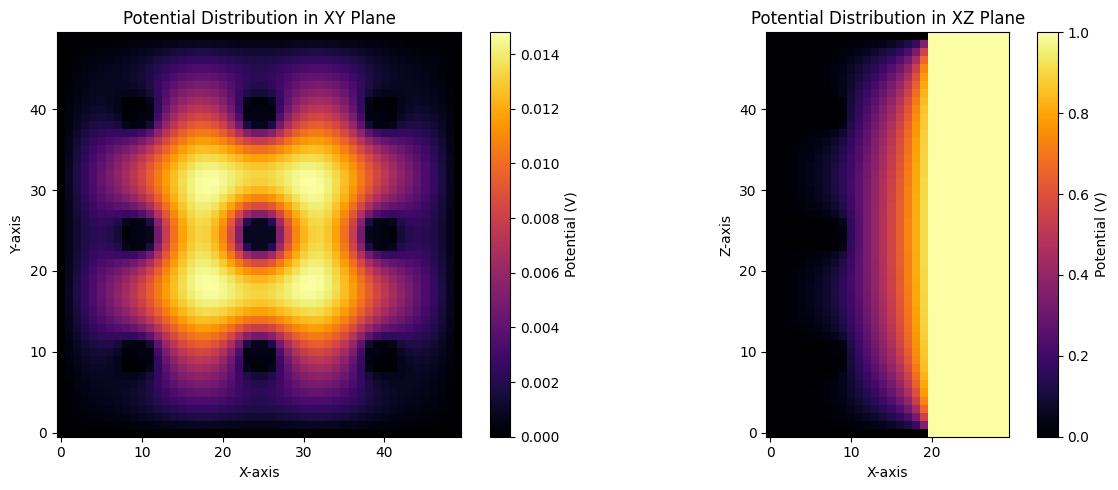

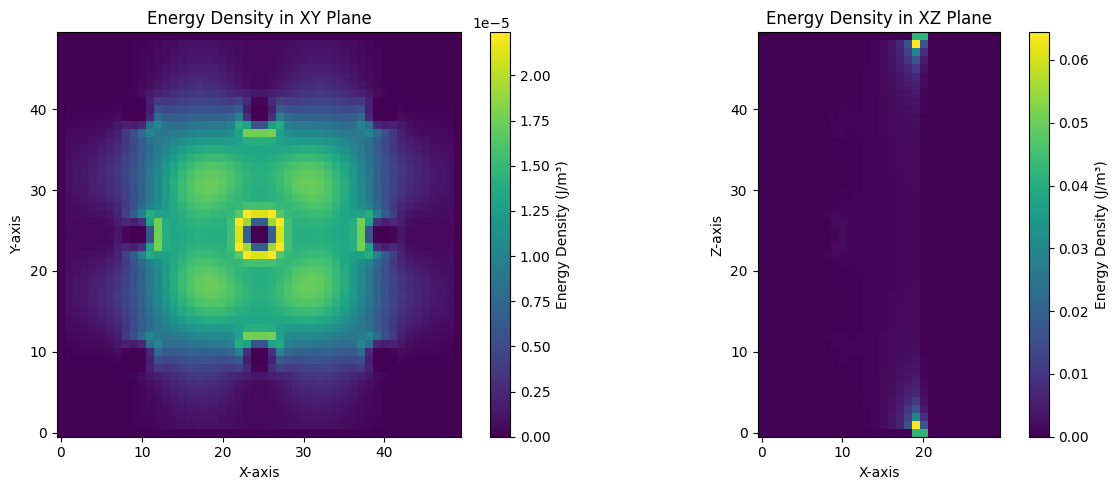

Total Energy: 1.58e+02 Joules


In [ ]:
plot_potential_distribution(V_grid)

energy_density, total_energy = calculate_energy_density(V_grid, a, b, c)
plot_energy_density(energy_density)
print(f"Total Energy: {total_energy:.2e} Joules")

In [40]:
def calculate_capacitance(V_grid, V_input, epsilon_0=8.854e-12, epsilon_r=10, a=1e-6, b=1e-6, c=1e-6):
    Nx, Ny, Nz = V_grid.shape
    
    Ex = np.zeros_like(V_grid)
    Ey = np.zeros_like(V_grid)
    Ez = np.zeros_like(V_grid)

    Ex[1:-1, :, :] = -(V_grid[2:, :, :] - V_grid[:-2, :, :]) / (2 * a)
    Ey[:, 1:-1, :] = -(V_grid[:, 2:, :] - V_grid[:, :-2, :]) / (2 * b)
    Ez[:, :, 1:-1] = -(V_grid[:, :, 2:] - V_grid[:, :, :-2]) / (2 * c)
    plate_z = 2 * height
    if plate_z >= Nz:
        plate_z = Nz - 1
    
    dV_dn = Ez[:, :, plate_z]
    
    dA = a * b
    Q = epsilon_0 * epsilon_r * np.sum(dV_dn) * dA
    C = abs(Q / V_input)
    
    return C


C = calculate_capacitance(V_grid, V_input)
print(f"Capacitance: {C:.2e} Farads")

Capacitance: 3.28e-14 Farads
